In [1]:
import pandas as pd
from datetime import datetime
from functools import reduce
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import missingno as msno

# Import custom functions
from stationarizer import simple_auto_stationarize

import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

from statsmodels.tsa.stattools import adfuller
''' Functions for numeric data preprocessing. '''
import statsmodels.stats.api as sms

from termcolor import colored
from arch.unitroot import ADF, PhillipsPerron, KPSS
from statsmodels.formula.api import ols


# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
cwd = os.getcwd()  # get current working directory

# Get the parent directory of the current working directory
grandparent_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

end_date = '2024-04-01'
end_date = datetime.strptime(end_date, '%Y-%m-%d')  # Convert end_date to datetime object
new_date = end_date - timedelta(days=1)  # Subtract 1 day from end_date

new_date_str = new_date.strftime('%Y-%m-%d')  # Convert new_date back to string format

# Load environment variables from .env file
load_dotenv()

# Import environment variables
start_date = os.getenv('start_date')
end_date = os.getenv('end_date')

## Master Data Table - Without Sentiment Data

In [3]:
df_final = pd.read_parquet(os.path.join(grandparent_dir, "data\\processed\\files\\processed_data.parquet.gzip"))

df_final.rename(columns={'value': 'btc_fear_and_greed_index'}, inplace=True)

columns_to_delete = ['BTC_VOLUME', 'value_classification', 'Adj_Close']

# Delete the specified columns
df_final = df_final.drop(columns=columns_to_delete)

# Convert column names to uppercase
df_final.columns = df_final.columns.str.upper()

df_final.columns = df_final.columns.str.replace(' ', '_')

# Fill missing values using forward fill
df_final['WUI'] = df_final['WUI'].ffill()
df_final['WUI'] = df_final['WUI'].apply(lambda x: float(x.replace(',', ''))).astype(float)
df_final['BTC_FEAR_AND_GREED_INDEX'] = df_final['BTC_FEAR_AND_GREED_INDEX'].astype(float)

df_final.set_index('DATE', inplace=True)

In [4]:
df_final.head()

,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME,GOLD_ADJ_CLOSE,SILVER_ADJ_CLOSE,OIL_ADJ_CLOSE,GOLD_VOLUME,SILVER_VOLUME,OIL_VOLUME,EUR_USD_ADJ_CLOSE,USD_JPY_ADJ_CLOSE,GBP_USD_ADJ_CLOSE,USD_CNY_ADJ_CLOSE,VIX_ADJ_CLOSE,CBOE_INTEREST_RATE_ADJ_CLOSE,TREASURY_YIELD_5YRS_ADJ_CLOSE,RUSSEL_2000_ADJ_CLOSE,ISHARES_20YR_ADJ_CLOSE,TREASURY_BILL_13WK_ADJ_CLOSE,RUSSEL_2000_VOLUME,ISHARES_20YR_VOLUME,TESLA_ADJ_CLOSE,AMD_ADJ_CLOSE,INTEL_ADJ_CLOSE,APPLE_ADJ_CLOSE,NVIDIA_ADJ_CLOSE,META_ADJ_CLOSE,GOOGLE_ADJ_CLOSE,TESLA_VOLUME,AMD_VOLUME,INTEL_VOLUME,APPLE_VOLUME,NVIDIA_VOLUME,META_VOLUME,GOOGLE_VOLUME,GBTC_ADJ_CLOSE,ARKB_ADJ_CLOSE,BITB_ADJ_CLOSE,FBTC_ADJ_CLOSE,BTCO_ADJ_CLOSE,IBIT_ADJ_CLOSE,HODL_ADJ_CLOSE,BITO_ADJ_CLOSE,GBTC_VOLUME,ARKB_VOLUME,BITB_VOLUME,FBTC_VOLUME,BTCO_VOLUME,IBIT_VOLUME,HODL_VOLUME,BITO_VOLUME,ETH_ADJ_CLOSE,ETH_VOLUME,USDT_ADJ_CLOSE,USDT_VOLUME,USDC_ADJ_CLOSE,USDC_VOLUME,DOGE_ADJ_CLOSE,DOGE_VOLUME,XRP_ADJ_CLOSE,XRP_VOLUME,SOL_ADJ_CLOSE,SOL_VOLUME,GAS_ADJ_CLOSE,GAS_VOLUME,GAS_USD,BTC_FEAR_AND_GREED_INDEX,EXTREME_FEAR,EXTREME_GREED,FEAR,GREED,NEUTRAL,SP500_ADJUSTED,GDP,RGDP,UNRATE,CPI,INTEREST_RATE_ADJUSTED,TREASURE_MATURITY_ADJUSTED,INFLATION_RATE_ADJUSTED,STICKY_CPI,M2_MONEY_STOCK_ADJUSTED,VOLUME_ADI,VOLUME_OBV,VOLUME_CMF,VOLUME_FI,VOLUME_EM,VOLUME_SMA_EM,VOLUME_VPT,VOLUME_VWAP,VOLUME_MFI,VOLUME_NVI,VOLATILITY_BBM,VOLATILITY_BBH,VOLATILITY_BBL,VOLATILITY_BBW,VOLATILITY_BBP,VOLATILITY_BBHI,VOLATILITY_BBLI,VOLATILITY_KCC,VOLATILITY_KCH,VOLATILITY_KCL,VOLATILITY_KCW,VOLATILITY_KCP,VOLATILITY_KCHI,VOLATILITY_KCLI,VOLATILITY_DCL,VOLATILITY_DCH,VOLATILITY_DCM,VOLATILITY_DCW,VOLATILITY_DCP,VOLATILITY_ATR,VOLATILITY_UI,TREND_MACD,TREND_MACD_SIGNAL,TREND_MACD_DIFF,TREND_SMA_FAST,TREND_SMA_SLOW,TREND_EMA_FAST,TREND_EMA_SLOW,TREND_VORTEX_IND_POS,TREND_VORTEX_IND_NEG,TREND_VORTEX_IND_DIFF,TREND_TRIX,TREND_MASS_INDEX,TREND_DPO,TREND_KST,TREND_KST_SIG,TREND_KST_DIFF,TREND_ICHIMOKU_CONV,TREND_ICHIMOKU_BASE,TREND_ICHIMOKU_A,TREND_ICHIMOKU_B,TREND_STC,TREND_ADX,TREND_ADX_POS,TREND_ADX_NEG,TREND_CCI,TREND_VISUAL_ICHIMOKU_A,TREND_VISUAL_ICHIMOKU_B,TREND_AROON_UP,TREND_AROON_DOWN,TREND_AROON_IND,TREND_PSAR_UP,TREND_PSAR_DOWN,TREND_PSAR_UP_INDICATOR,TREND_PSAR_DOWN_INDICATOR,MOMENTUM_RSI,MOMENTUM_STOCH_RSI,MOMENTUM_STOCH_RSI_K,MOMENTUM_STOCH_RSI_D,MOMENTUM_TSI,MOMENTUM_UO,MOMENTUM_STOCH,MOMENTUM_STOCH_SIGNAL,MOMENTUM_WR,MOMENTUM_AO,MOMENTUM_ROC,MOMENTUM_PPO,MOMENTUM_PPO_SIGNAL,MOMENTUM_PPO_HIST,MOMENTUM_PVO,MOMENTUM_PVO_SIGNAL,MOMENTUM_PVO_HIST,MOMENTUM_KAMA,OTHERS_DR,OTHERS_DLR,OTHERS_CR,UNIQUE_USERS,FOLLOWERS,TWEET_COUNT,BTC_PERCENTAGE_DOMINANCE,ETH_PERCENTAGE_DOMINANCE,USDT_PERCENTAGE_DOMINANCE,BNB_PERCENTAGE_DOMINANCE,SOL_PERCENTAGE_DOMINANCE,OTHERS_PERCENTAGE_DOMINANCE,GPR,GPRT,GPRA,GPRH,GPRHT,GPRHA,SHARE_GPR,N10,SHARE_GPRH,N3H,GPRH_NOEW,GPR_NOEW,GPRH_AND,GPR_AND,GPRH_BASIC,GPR_BASIC,SHAREH_CAT_1,SHAREH_CAT_2,SHAREH_CAT_3,SHAREH_CAT_4,SHAREH_CAT_5,SHAREH_CAT_6,SHAREH_CAT_7,SHAREH_CAT_8,GPRC_ARG,GPRC_AUS,GPRC_BEL,GPRC_BRA,GPRC_CAN,GPRC_CHE,GPRC_CHL,GPRC_CHN,GPRC_COL,GPRC_DEU,GPRC_DNK,GPRC_EGY,GPRC_ESP,GPRC_FIN,GPRC_FRA,GPRC_GBR,GPRC_HKG,GPRC_HUN,GPRC_IDN,GPRC_IND,GPRC_ISR,GPRC_ITA,GPRC_JPN,GPRC_KOR,GPRC_MEX,GPRC_MYS,GPRC_NLD,GPRC_NOR,GPRC_PER,GPRC_PHL,GPRC_POL,GPRC_PRT,GPRC_RUS,GPRC_SAU,GPRC_SWE,GPRC_THA,GPRC_TUN,GPRC_TUR,GPRC_TWN,GPRC_UKR,GPRC_USA,GPRC_VEN,GPRC_VNM,GPRC_ZAF,GPRHC_ARG,GPRHC_AUS,GPRHC_BEL,GPRHC_BRA,GPRHC_CAN,GPRHC_CHE,GPRHC_CHL,GPRHC_CHN,GPRHC_COL,GPRHC_DEU,GPRHC_DNK,GPRHC_EGY,GPRHC_ESP,GPRHC_FIN,GPRHC_FRA,GPRHC_GBR,GPRHC_HKG,GPRHC_HUN,GPRHC_IDN,GPRHC_IND,GPRHC_ISR,GPRHC_ITA,GPRHC_JPN,GPRHC_KOR,GPRHC_MEX,GPRHC_MYS,GPRHC_NLD,GPRHC_NOR,GPRHC_PER,GPRHC_PHL,GPRHC_POL,GPRHC_PRT,GPRHC_RUS,GPRHC_SAU,GPRHC_SWE,GPRHC_THA,GPRHC_TUN,GPRHC_TUR,GPRHC_TWN,GPRHC_UKR,GPRHC_USA,GPRHC_VEN,GPRHC_VNM,GPRHC_ZAF,MARKET_CAP,CRYPTO_VOLUME_24,WTUI,WUI,BTC_DAILY_ABSOLUTE_CHANGE,BTC_DAILY_RETURNS_PERC,BTC_LOG_DIFFERENCE,BTC_PRICE_MIN_7D,BTC_PRICE_MAX_7D,BTC_PRICE_MIN_14D,BTC_PRICE_MAX_14D,BTC_PRICE_MIN_21D,BTC_PRICE_MAX_21D,BTC_PRICE_MIN_30D,BTC_PRICE_MAX_30D,BTC

In [7]:
df_final.to_csv(os.path.join(grandparent_dir, "data\\processed\\files\\final_df_without_stationarity_test.csv"))

In [5]:
df_final.to_parquet(os.path.join(grandparent_dir, "data\\processed\\files\\final_df_without_stationarity_test.parquet.gzip"), compression='gzip')

### Y variable - Targets

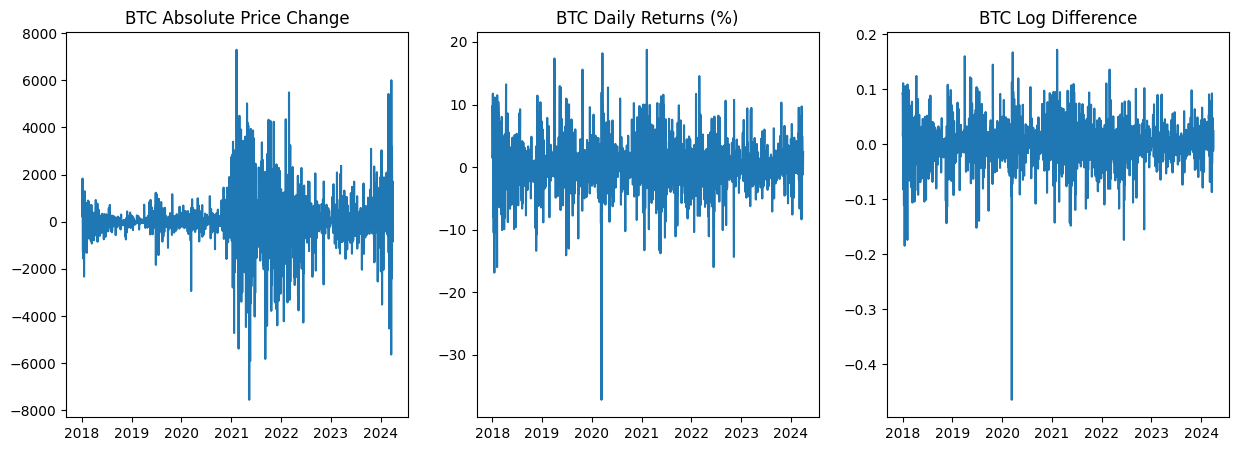

In [5]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(df_final.BTC_DAILY_ABSOLUTE_CHANGE)
ax[0].set_title('BTC Absolute Price Change')
ax[1].plot(df_final.BTC_DAILY_RETURNS_PERC)
ax[1].set_title('BTC Daily Returns (%)')
ax[2].plot(df_final.BTC_LOG_DIFFERENCE)
ax[2].set_title('BTC Log Difference')
plt.show()

In [6]:
btc_target = ['BTC_DAILY_RETURNS_PERC']

## Check for NaNs

In [6]:
# msno.bar(df_final)

## Check for outliers

In [7]:
# def remove_outliers_fillna(df: pd.DataFrame, threshold: float = 3.0, method: str = 'ffill'):
#     ''' Remove outliers from each column of a DataFrame based on Z-Score method and fill NaNs '''

#     # Create a copy of the original DataFrame
#     df_cleaned = df.copy()

#     # Calculate Z-Score for each column
#     outliers_percentage = {}
#     for col in df.columns:
#         z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
#         outliers_percentage[col] = (z_scores > threshold).mean() * 100  # Calculate percentage of outliers
#         df_cleaned.loc[z_scores > threshold, col] = np.nan  # Replace outliers with NaNs

#     # Fill NaNs using specified method
#     if method == 'ffill':
#         df_cleaned = df_cleaned.ffill()
#     elif method == 'bfill':
#         df_cleaned = df_cleaned.bfill()
#     elif method == 'interpolation':
#         df_cleaned = df_cleaned.interpolate()

#     # Sort outliers_percentage dictionary by values in descending order
#     outliers_percentage_sorted = dict(sorted(outliers_percentage.items(), key=lambda x: x[1], reverse=True))

#     return df_cleaned, outliers_percentage_sorted

### Correlation

In [8]:
# numerical_cols = list(set(df_final.select_dtypes(include=[np.number]).columns) - set([
#     'BTC_DAILY_ABSOLUTE_CHANGE',
#     'BTC_DAILY_RETURNS_PERC',
#     'BTC_LOG_DIFFERENCE'
# ]))

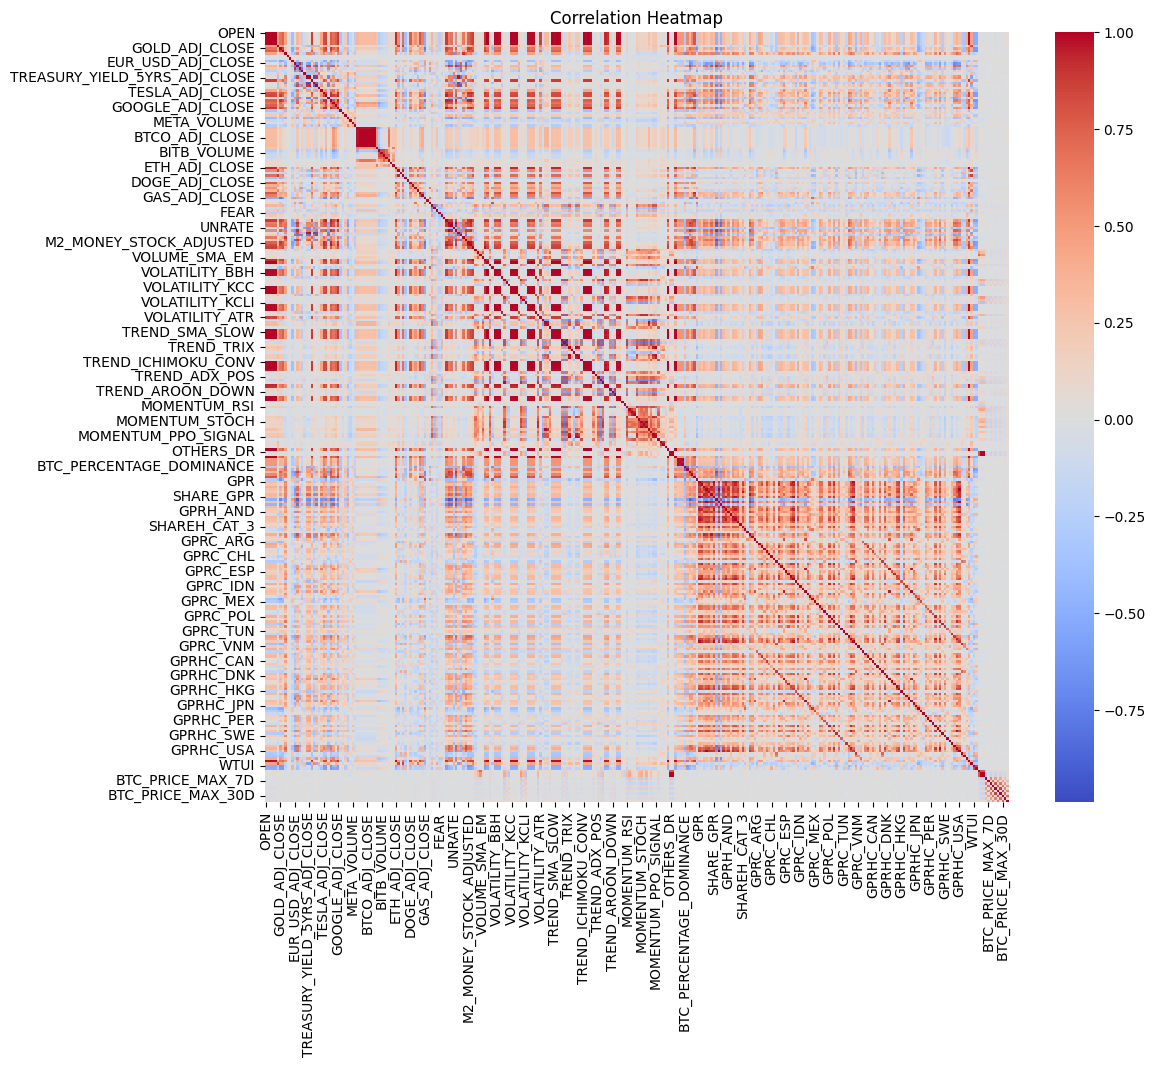

In [7]:
# Calculate the correlation matrix
correlation_matrix = df_final.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## Stationarity - Unit root testing

In [9]:
def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [11]:
# for column in df_final.select_dtypes(include='number').columns:
#     print("Checking stationarity for column:", column)
#     check_stationarity(df_final[column])
#     print()

#### Heteroskedasticity

In [10]:
# Heteroskedasticity tests
class HeskedTesting:

    TEST_NAMES = ['White', 'Breusch-Pagan', 'Goldfeld-Quandt']
    non_stationary_columns = []  # List to store non-stationary columns


    @staticmethod
    def het_tests(series: pd.Series, test: str) -> float:
        '''
        Testing for heteroskedasticity

        :param series: Univariate time series as pd.Series
        :param test: String denoting the test. One of 'white','goldfeldquandt', or 'breuschpagan'

        :return: p-value as a float.

        If the p-value is high, we accept the null hypothesis that the data is homoskedastic
        '''
        series = series.reset_index(drop=True).reset_index()
        series.columns = ['time', 'value']
        series['time'] += 1

        olsr = ols('value ~ time', series).fit()

        if test == 'White':
            _, p_value, _, _ = sms.het_white(olsr.resid, olsr.model.exog)
        elif test == 'Goldfeld-Quandt':
            _, p_value, _ = sms.het_goldfeldquandt(
                olsr.resid, olsr.model.exog, alternative='two-sided')
        else:
            _, p_value, _, _ = sms.het_breuschpagan(
                olsr.resid, olsr.model.exog)

        return p_value

    @classmethod
    def run_all_tests(cls, df: pd.DataFrame, conf: float = 0.05, tabsize: int = 30):

        print('Results of White, Breusch-Pagan and Goldfeld-Quandt tests by column (p-values):\n')

        for column in df.columns:
            p_vals = {}
            for test in cls.TEST_NAMES:
                p_value = cls.het_tests(df[column].dropna(), test)
                if p_value <= conf:
                    p_vals[test] = colored(f'{p_value:.4f}', 'red')
                    cls.non_stationary_columns.append(column)  # Store non-stationary column
                else:
                    p_vals[test] = colored(f'{p_value:.4f}', 'green')

            print(
                f'{column} --\t White: {p_vals["White"]},\tBreusch-Pagan: {p_vals["Breusch-Pagan"]},\tGoldfeld-Quandt: {p_vals["Goldfeld-Quandt"]}'.expandtabs(tabsize))

In [13]:
# HeskedTesting.run_all_tests(df_final, conf=0.05, tabsize=58)

## Unit Root Testing

In [11]:
def unit_root_testing(df: pd.DataFrame, conf: float = 0.05, verbose: bool = False, tabsize: int = 30):
    ''' 
    Checks stationarity of all columns of a given pandas df using
    • Augmented Dickey-Fuller (ADF), 
    • Phillips-Perron (PP)
    • Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
    unit root tests. 
    '''
    def print_result(name, p_value):
        if p_value <= conf:
            return colored(f'{p_value:.4f}', "green")  # Reject null hypothesis
        else:
            return colored(f'{p_value:.4f}', "red")    # Don't reject null hypothesis

    if verbose:
        print('ADF test:\n H0: unit root, H1: stationarity\n')
        for column in df.columns:
            p_value = np.round(ADF(df[column].dropna()).pvalue, 5)
            reject = p_value <= conf
            print(f' {column} : \tp = {print_result("ADF", p_value)} {"<" if reject else ">"} {conf} \t-> {"reject" if reject else "don`t reject"} H0 @ {100*conf}% conf.'.expandtabs(tabsize))

        print('\n------------------------------------------------------------------------------------------\n')     
        print('PP test:\n H0: unit root, H1: stationarity\n')
        for column in df.columns:
            p_value = np.round(PhillipsPerron(df[column].dropna()).pvalue, 5)
            reject = p_value <= conf
            print(f' {column} : \tp = {print_result("PP", p_value)} {"<" if reject else ">"} {conf} \t-> {"reject" if reject else "don`t reject"} H0 @ {100*conf}% conf.'.expandtabs(tabsize))

        print('\n------------------------------------------------------------------------------------------\n')     
        print('KPSS test:\n H0: stationarity, H1: unit root\n')
        for column in df.columns:
            p_value = np.round(KPSS(df[column].dropna()).pvalue, 5)
            reject = p_value > conf
            print(f' {column} : \tt = {print_result("KPSS", p_value)} {"<" if reject else ">"} {conf} \t-> {"reject" if reject else "don`t reject"} H0 @ {100*conf}% conf.'.expandtabs(tabsize))

    else:
        print('Results of ADF, PP and KPSS tests by column (p-values):\n')
        for column in df.columns:
            try:
                p_value = ADF(df[column].dropna()).pvalue
                ADF_result = print_result("ADF", p_value)
            except Exception as e:
                ADF_result = colored(type(e).__name__, "cyan")

            try:
                p_value = PhillipsPerron(df[column].dropna()).pvalue
                PP_result = print_result("PP", p_value)
            except Exception as e:
                PP_result = colored(type(e).__name__, "cyan")

            try:
                p_value = KPSS(df[column].dropna()).pvalue
                KPSS_result = print_result("KPSS", p_value)
            except Exception as e:
                KPSS_result = colored(type(e).__name__, "cyan")

            print(f'{column} --\t ADF: {ADF_result},\tPP: {PP_result},\tKPSS: {KPSS_result}'.expandtabs(tabsize))


In [15]:
# # Perform unit root testing on the numerical columns
# unit_root_testing(df_final, conf=0.05, tabsize=50)

## Stationarize df


In [16]:
def plot_acf_dataframe(df: pd.DataFrame, lags: int = 20, zero = False):
    ''' Plot ACF for each column in the DataFrame '''

    # Iterate over each column in the DataFrame
    for col in df.columns:
        fig, ax = plt.subplots(figsize=(10, 5))
        plot_acf(df[col].dropna(), ax=ax, lags=lags, zero=zero)
        ax.set_title(f'Autocorrelation for {col}')
        ax.set_xlabel('Lag')
        ax.set_ylabel('Autocorrelation')
        plt.show()

In [17]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [21]:
stationarized_df = simple_auto_stationarize(df_final)

In [18]:
# plot_acf_dataframe(stationarized_df, lags=30, zero = False)

## Final Dataset

In [18]:
columns_to_remove = ['CLOSE', 'ADJ_CLOSE', 'BTC_DAILY_ABSOLUTE_CHANGE', 'BTC_LOG_DIFFERENCE']

stationarized_df = stationarized_df.drop(columns=columns_to_remove)

stationarized_df['BTC_DAILY_RETURNS_PERC'] = stationarized_df.pop('BTC_DAILY_RETURNS_PERC')

C:\Users\Stamatis\AppData\Local\Temp\ipykernel_46196\3831093042.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  stationarized_df['BTC_DAILY_RETURNS_PERC'] = stationarized_df.pop('BTC_DAILY_RETURNS_PERC')


In [24]:
# stationarized_df.corr()['BTC_DAILY_RETURNS_PERC'].sort_values(ascending=False)

In [25]:
stationarized_df.to_parquet(os.path.join(grandparent_dir, "data\\processed\\files\\final_stationarized_data.parquet.gzip"), compression='gzip')